## Music Genre Classification
---



### Initial Setup and Functions


In [3]:
# dependencies

!sudo apt-get install -y ffmpeg --quiet
!pip install librosa --quiet
!pip install imageio --quiet
!pip install imageio-ffmpeg --quiet
!pip install tqdm
!pip install torchsummary

# !pip3 install chardet
# !pip install matplotlib
# caso de problema pip install --force-reinstall charset-normalizer==3.1.0


Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [4]:
# imports

import os
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
import librosa.display
from typing import cast
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from functools import partial
import gc
import random
from zipfile import ZipFile
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(42)

cuda


In [5]:
# Separates mel-spectograms dataset in train and test files.
# Proportion: 80:10:10

def split_dataset(name):
  img_dir = "Data/"+name
  train_dir = 'train_'+name+'/'
  test_dir = 'test_'+name+'/'
  val_dir = 'val_'+name+'/'

  if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
    os.mkdir(train_dir)
  else:
    os.mkdir(train_dir)

  if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
    os.mkdir(test_dir)
  else:
    os.mkdir(test_dir)

  if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
    os.mkdir(val_dir)
  else:
    os.mkdir(val_dir)

  genres = list(os.listdir(img_dir))
  for genre in genres:
    # splits the dataset in the proportion mentioned above.
    src_file_paths= []

    for im in glob.glob(os.path.join(img_dir, f'{genre}',"*.npy"), recursive=True):
      src_file_paths.append(im)

    test_files = src_file_paths[0:10]
    train_files = src_file_paths[20:]
    val_files = src_file_paths[10:20]

  #  creates folder for each gender.
    if not os.path.exists(os.path.join(train_dir + f"{genre}")):
      os.mkdir(os.path.join(train_dir + f"{genre}"))

    if not os.path.exists(os.path.join(test_dir + f"{genre}")):
      os.mkdir(os.path.join(test_dir + f"{genre}"))

    if not os.path.exists(os.path.join(val_dir + f"{genre}")):
      os.mkdir(os.path.join(val_dir + f"{genre}"))

    # add each file to the respective folder.
    for f in train_files:
      shutil.copy(f, os.path.join(os.path.join(train_dir + f"{genre}") + '/',os.path.split(f)[1]))
    for f in test_files:
      shutil.copy(f, os.path.join(os.path.join(test_dir + f"{genre}") + '/',os.path.split(f)[1]))
    for f in val_files:
      shutil.copy(f, os.path.join(os.path.join(val_dir + f"{genre}") + '/',os.path.split(f)[1]))

  return train_dir, test_dir, val_dir


In [6]:
# Loadings
def npy_loader(path):
    sample = torch.Tensor(np.expand_dims(np.load(path),axis=0))
    return sample

def load_dataset(train_dir, test_dir, val_dir):
  train_dataset = datasets.DatasetFolder(
      root=train_dir,
      loader=npy_loader,
      extensions=['.npy']
  )

  train_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size=16, drop_last=True, shuffle=True, num_workers=1, pin_memory=True)

  test_dataset = datasets.DatasetFolder(
      root=test_dir,
      loader=npy_loader,
      extensions=['.npy']
  )

  test_loader = torch.utils.data.DataLoader(
      test_dataset, batch_size=16, shuffle=True, drop_last=True, num_workers=1, pin_memory=True)

  val_dataset = datasets.DatasetFolder(
      root=val_dir,
      loader=npy_loader,
      extensions=['.npy']
  )

  val_loader = torch.utils.data.DataLoader(
      val_dataset, batch_size=16, shuffle=True, drop_last=True, num_workers=1, pin_memory=True)

  return train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader

In [7]:
# Training and validation for each epoch

def train_epoch(model,device,dataloader,loss_fn,optimizer, scheduler):
    train_loss,train_correct=0.0,0
    model.train()

    for i, (data, target) in enumerate(dataloader):
        data = data.to(device)
        target = target.to(device)

        #Forward pass
        outputs = model(data)
        loss =  loss_fn(outputs, target)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # get loss
        train_loss += loss.item()
        scheduler.step()

        # get accuracy
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == target).sum().item()
    return train_loss,train_correct


def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval() #  eliminate dropouts

    for data, target in dataloader:
      data = data.to(device)
      target = target.to(device)

      # Forward pass
      output = model(data)

      # get loss
      loss = loss_fn(output, target)
      valid_loss += loss.item()

      # get accuracy
      _, predicted = torch.max(output, 1)
      val_correct += (predicted == target).sum().item()
    return valid_loss,val_correct

In [8]:
def early_stop(train_loss, best_loss, min_delta, patiance, last_upgrade):
    if(best_loss-train_loss) < min_delta:
        last_upgrade+=1
        print("Time since last upgrade " + last_upgrade + "best_loss " + best_loss + "current loss " + train_loss + "min delta " + min_delta)
        if(patiance < last_upgrade):
            return False

    else:
        best_loss = train_loss
        return False

In [9]:
def train(mod, opt_fn, num_epochs, dataset, name):

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = mod.to(device)
  optimizer = opt_fn(model.parameters())

  torch.save(model,'k_cross_CNN_'+name+'.pt')

  for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

      print('Fold {}'.format(fold + 1))

      model = torch.load('k_cross_CNN_'+name+'.pt')
      optimizer = opt_fn(model.parameters())

      # used during the lr experiment only.
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=5, min_lr=0.000016) # min_lr provided by the article.

      train_sampler = SubsetRandomSampler(train_idx)
      val_sampler = SubsetRandomSampler(val_idx)

      train_loader = DataLoader(dataset, batch_size=16, sampler=train_sampler)
      val_loader = DataLoader(dataset, batch_size=16, sampler=val_sampler)

      train_loader_size = len(train_loader.sampler)
      val_loader_size = len(val_loader.sampler)

      history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}

      for epoch in range(num_epochs):
          train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer, scheduler)

          val_loss, val_correct=valid_epoch(model,device,val_loader,criterion, scheduler)

          train_loss = train_loss / train_loader_size
          train_acc = train_correct / train_loader_size * 100
          val_loss = val_loss / val_loader_size
          val_acc = val_correct / val_loader_size * 100

          # if(early_stop(train_loss, best_loss, min_delta, patiance, last_upgrade)):
          #     break

          print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Val Loss:{:.3f} AVG Training Acc {:.2f} % AVG Val Acc {:.2f} %".format(epoch + 1,
                                                                                                              num_epochs,
                                                                                                              train_loss,
                                                                                                              val_loss,
                                                                                                              train_acc,
                                                                                                              val_acc))
          history['train_loss'].append(train_loss)
          history['val_loss'].append(val_loss)
          history['train_acc'].append(train_acc)
          history['val_acc'].append(val_acc)

      results['fold{}'.format(fold+1)] = history


  torch.save(model,'k_cross_CNN_'+name+'.pt')

  return results

In [10]:
def eval(model,dataloader):
    acc = 0
    test_correct = 0
    siz = 0
    model=model.to(device)
    model.eval()

    for i, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)

        outputs = model(data)

        # get accuracy
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == target).sum().item()

    acc = (test_correct/len(dataloader.dataset))*100
    print(f'Test Acc = {acc}%')

    return acc

In [11]:
# average perfomances of the folds

def get_results(resuts):

  testl_f,tl_f,testa_f,ta_f=[],[],[],[]
  results_cpu = results

  for f in range(1,k_folds+1):
      results_cpu['fold{}'.format(f)]['train_loss'] = torch.tensor(results_cpu['fold{}'.format(f)]['train_loss'], device = 'cpu')
      results_cpu['fold{}'.format(f)]['val_loss'] = torch.tensor(results_cpu['fold{}'.format(f)]['val_loss'], device = 'cpu')
      results_cpu['fold{}'.format(f)]['train_acc'] = torch.tensor(results_cpu['fold{}'.format(f)]['train_acc'], device = 'cpu')
      results_cpu['fold{}'.format(f)]['val_acc'] = torch.tensor(results_cpu['fold{}'.format(f)]['val_acc'], device = 'cpu')

  for f in range(1,k_folds+1):

      tl_f.append(torch.mean(results_cpu['fold{}'.format(f)]['train_loss']))
      testl_f.append(torch.mean(results_cpu['fold{}'.format(f)]['val_loss']))

      ta_f.append(torch.mean(results_cpu['fold{}'.format(f)]['train_acc']))
      testa_f.append(torch.mean(results_cpu['fold{}'.format(f)]['val_acc']))

  print('Performance of {} fold cross validation'.format(k_folds))
  print("Average Training Loss: {:.3f} \t Average Val Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Val Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))

  return results_cpu

In [12]:
def plot_results(results_cpu):
  # Epoch analysis

  diz_ep = {'train_loss_ep':[],'val_loss_ep':[],'train_acc_ep':[],'val_acc_ep':[]}

  for i in range(num_epochs):
        diz_ep['train_loss_ep'].append(np.mean([results_cpu['fold{}'.format(f+1)]['train_loss'][i] for f in range(k_folds)]))
        diz_ep['val_loss_ep'].append(np.mean([results_cpu['fold{}'.format(f+1)]['val_loss'][i] for f in range(k_folds)]))
        diz_ep['train_acc_ep'].append(np.mean([results_cpu['fold{}'.format(f+1)]['train_acc'][i] for f in range(k_folds)]))
        diz_ep['val_acc_ep'].append(np.mean([results_cpu['fold{}'.format(f+1)]['val_acc'][i] for f in range(k_folds)]))

  # Plots

  # Losses
  plt.figure(figsize=(10,8))
  plt.semilogy(diz_ep['train_loss_ep'], label='Train')
  plt.semilogy(diz_ep['val_loss_ep'], label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  #plt.grid()
  plt.legend()
  plt.title('CNN loss')
  plt.show()

  # Accuracies
  plt.figure(figsize=(10,8))
  plt.semilogy(diz_ep['train_acc_ep'], label='Train')
  plt.semilogy(diz_ep['val_acc_ep'], label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  #plt.grid()
  plt.legend()
  plt.title('CNN accuracy')
  plt.show()

### Dataset

The dataset chosen was **GTZAN**, which is compounded by 1000 songs, 30 seconds long, divided equally in 10 genres:

* blues
* classical
* country
* disco
* hiphop
* jazz
* metal
* pop
* reggae
* rock

**Dataset Total Size:** 3.71 GiB

**Audio Format:** 22050 Hz Mono 16-bit audio files in .wav format

**Mel Spectrograms format:** 438x288 .png format


In [13]:

# GTZAN (from Kaggle: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification)
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

with ZipFile("/content/gtzan-dataset-music-genre-classification.zip", 'r') as zipObj:
  zipObj.extractall()

 99% 1.20G/1.21G [00:13<00:00, 53.6MB/s]
100% 1.21G/1.21G [00:13<00:00, 96.7MB/s]


In [14]:
# Visualizing data (also includes mel spectograms, made with librosa)
sample_path = 'Data/genres_original/jazz/jazz.00053.wav'

display.Audio(sample_path)

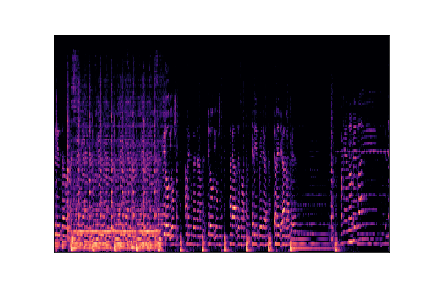

(432, 288)


In [15]:
mel_sample_path = 'Data/images_original/rock/rock00000.png'
from PIL import Image
im = Image.open(mel_sample_path)
im.show()
print(im.size)

### Frame-Level Mel-Spectogram Model

### The Data

Starting from a raw signal, the idea behind spectrograms is to extract useful information from data, in this case, mapping an audio signal from the time domain to the frequency domain using, for example, Fast Fourier Transformations.

The Mel spectrogram uses the Mel scale, proposed by Stevens, Volkmann, and Newmann in 1937, applying a transformation, as described below, on the frequency domain to represent the audio focusing on frequencies human beings are skilled to hear better.

\begin{equation}
Mel(f) = 2595 × log_{10}(1 + \frac{f}{700}
)
\end{equation}

Even, with the dataset given us the mel spectrograms of each songs we decided to generate our own data to learn and format the input size as described in the article.
### The Model

We decided to use a fully convolutional neural network (FCN) as proposed in the article named "Automatic Tagging Using Deep Convolutional Neural Networks" by Keunwoo Choi, et al. [2], because it was cited in the article we are trying to reproduce and also, it has more details about the model configuration:

- Mel-Spectogram input: 96x1366x1
- Conv: 3x3x128
- Max Pooling (2,4): 48x341x128
- Conv: 3x3x384
- Max Pooling (4,5): 24x85x384
- Conv: 3x3x768
- Max Pooling (3,8): 12x21x768
- Conv: 3x3x2048
- Max Pooling (4,8): 1x1x2048
- Output: 50x1 (sigmoid)


As our datasets only have 10 tags, we'll work with 10x1 on the output.


In [64]:
# Generating our own melgrams.

audio_dir = "Data/genres_original"

img_gen_dir = 'Data/mel_gen/'
if os.path.exists(img_gen_dir):
  shutil.rmtree(img_gen_dir)
  os.mkdir(img_gen_dir)
else:
  os.mkdir(img_gen_dir)

SR = 12000
N_FFT = 512
N_MELS = 96
HOP_LEN = 256
DURA = 29.12  # 1366 frames
genres = list(os.listdir(audio_dir))
for genre in genres:
  # creates folder for the gender.
  if not os.path.exists(os.path.join(img_gen_dir + f"{genre}")):
    os.mkdir(os.path.join(img_gen_dir + f"{genre}"))

  # add each file to the respective folder.
  for audio in glob.glob(os.path.join(audio_dir, f'{genre}',"*.wav"), recursive=True):
    if audio == "Data/genres_original/jazz/jazz.00054.wav":     # faulty audio
      continue

    # Generate a new melgram
    src, sr = librosa.load(audio, sr=SR)  # whole signal
    n_sample = src.shape[0]
    n_sample_fit = int(DURA*SR)

    if n_sample < n_sample_fit:  # if too short
        src = np.hstack((src, np.zeros((int(DURA*SR) - n_sample,))))
    elif n_sample > n_sample_fit:  # if too long
        src = src[int((n_sample-n_sample_fit)/2):int((n_sample+n_sample_fit)/2)]
    melgram = librosa.feature.melspectrogram(y=src, sr=SR, hop_length=HOP_LEN,
                            n_fft=N_FFT, n_mels=N_MELS)
    melgram_DB = librosa.power_to_db(melgram, ref=np.max)

    # Save ndarray.
    np.save(os.path.join(img_gen_dir + audio[21:-3].replace(".","")+".npy"), melgram_DB)

In [65]:
# spliting dataset in train, test, val
train_dir, test_dir, val_dir = split_dataset('mel_gen')

In [66]:
# loading dataset
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = load_dataset(train_dir, test_dir, val_dir)

In [67]:
# CNN modeling as described in [2].

# input: 96×1366×1
class mel_net(nn.Module):
  def __init__(self):
    super().__init__()

    # Conv 3×3×128 - MP (2, 4) (output: 48×341×128)
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,4)),
        nn.Dropout(p=0.5)
    )

    # Conv 3×3×384 - MP (4, 5) (output: 24×85×384) ( MP(2,4) here, to receive the same output as the article)
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=384, kernel_size=3),
        nn.BatchNorm2d(num_features=384),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,4)),
        nn.Dropout(p=0.5)
    )

    # Conv 3×3×768 - MP (3, 8) (output: 12×21×768)
    self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels=384, out_channels=768, kernel_size=3),
        nn.BatchNorm2d(num_features=768),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(3,8)),
        nn.Dropout(p=0.5)
    )

    # Conv 3×3×2048 - MP (4, 8) (output: 1×1×2048)
    self.layer4 = nn.Sequential(
        nn.Conv2d(in_channels=768, out_channels=2048, kernel_size=1),
        nn.BatchNorm2d(num_features=2048),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,8)),
        nn.Dropout(p=0.5)
    )

    # Output 10×1 (sigmoid)
    self.dense = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=2048, out_features=10),
        nn.Sigmoid()
    )

  def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = self.layer3(out)
      out = self.layer4(out)
      out = self.dense(out)
      return out

In [70]:
model = mel_net().to(device)
summary(model, (1,96,1366))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 94, 1364]           1,280
       BatchNorm2d-2        [-1, 128, 94, 1364]             256
              ReLU-3        [-1, 128, 94, 1364]               0
         MaxPool2d-4         [-1, 128, 47, 341]               0
           Dropout-5         [-1, 128, 47, 341]               0
            Conv2d-6         [-1, 384, 45, 339]         442,752
       BatchNorm2d-7         [-1, 384, 45, 339]             768
              ReLU-8         [-1, 384, 45, 339]               0
         MaxPool2d-9          [-1, 384, 22, 84]               0
          Dropout-10          [-1, 384, 22, 84]               0
           Conv2d-11          [-1, 768, 20, 82]       2,654,976
      BatchNorm2d-12          [-1, 768, 20, 82]           1,536
             ReLU-13          [-1, 768, 20, 82]               0
        MaxPool2d-14           [-1, 768

In [ ]:
dataset = ConcatDataset([train_dataset, val_dataset])

k_folds = 5
num_epochs = 50
criterion = nn.CrossEntropyLoss()
splits=KFold(n_splits=k_folds,shuffle=True,random_state=42)
results = {}


results = train(model, partial(torch.optim.Adam, lr=0.001), num_epochs, dataset, 'mel_gen')

Fold 1
Epoch:1/50 AVG Training Loss:0.147 AVG Val Loss:0.155 AVG Training Acc 9.60 % AVG Val Acc 15.56 %
Epoch:2/50 AVG Training Loss:0.141 AVG Val Loss:0.150 AVG Training Acc 15.02 % AVG Val Acc 13.33 %
Epoch:3/50 AVG Training Loss:0.138 AVG Val Loss:0.147 AVG Training Acc 16.69 % AVG Val Acc 13.89 %
Epoch:4/50 AVG Training Loss:0.135 AVG Val Loss:0.151 AVG Training Acc 22.53 % AVG Val Acc 12.78 %
Epoch:5/50 AVG Training Loss:0.134 AVG Val Loss:0.151 AVG Training Acc 23.09 % AVG Val Acc 12.78 %
Epoch:6/50 AVG Training Loss:0.134 AVG Val Loss:0.147 AVG Training Acc 22.95 % AVG Val Acc 20.56 %
Epoch:7/50 AVG Training Loss:0.134 AVG Val Loss:0.147 AVG Training Acc 23.92 % AVG Val Acc 18.33 %
Epoch:8/50 AVG Training Loss:0.134 AVG Val Loss:0.147 AVG Training Acc 23.09 % AVG Val Acc 18.33 %
Epoch:9/50 AVG Training Loss:0.134 AVG Val Loss:0.144 AVG Training Acc 23.50 % AVG Val Acc 20.56 %
Epoch:10/50 AVG Training Loss:0.133 AVG Val Loss:0.148 AVG Training Acc 24.48 % AVG Val Acc 22.22 %
Epo

In [ ]:
# get results
results_cpu = get_results(results)

Performance of 5 fold cross validation
Average Training Loss: 0.129 	 Average Val Loss: 0.142 	 Average Training Acc: 33.28 	 Average Val Acc: 29.35


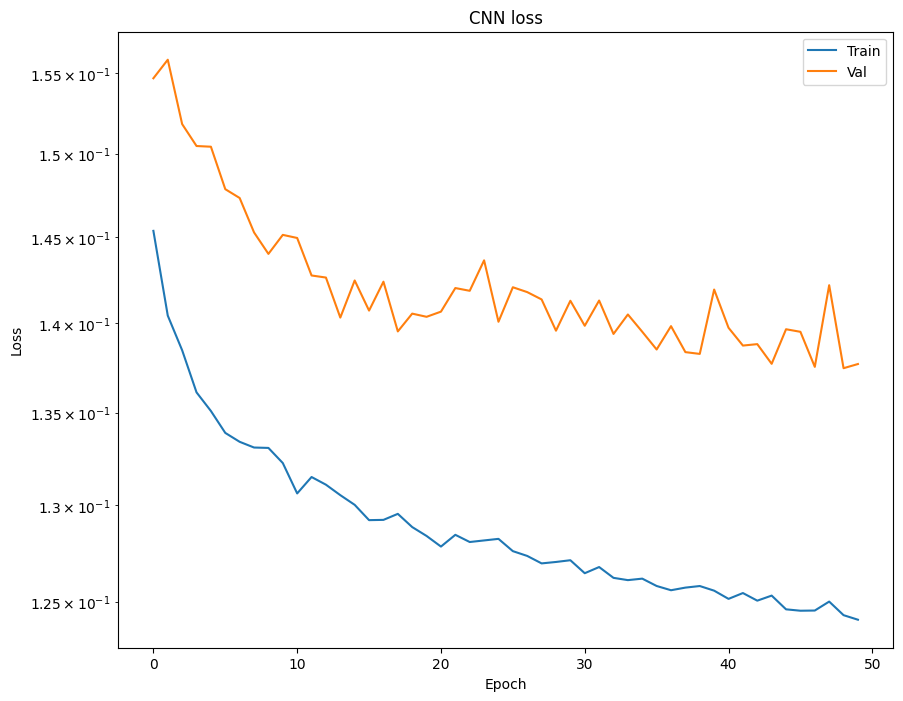

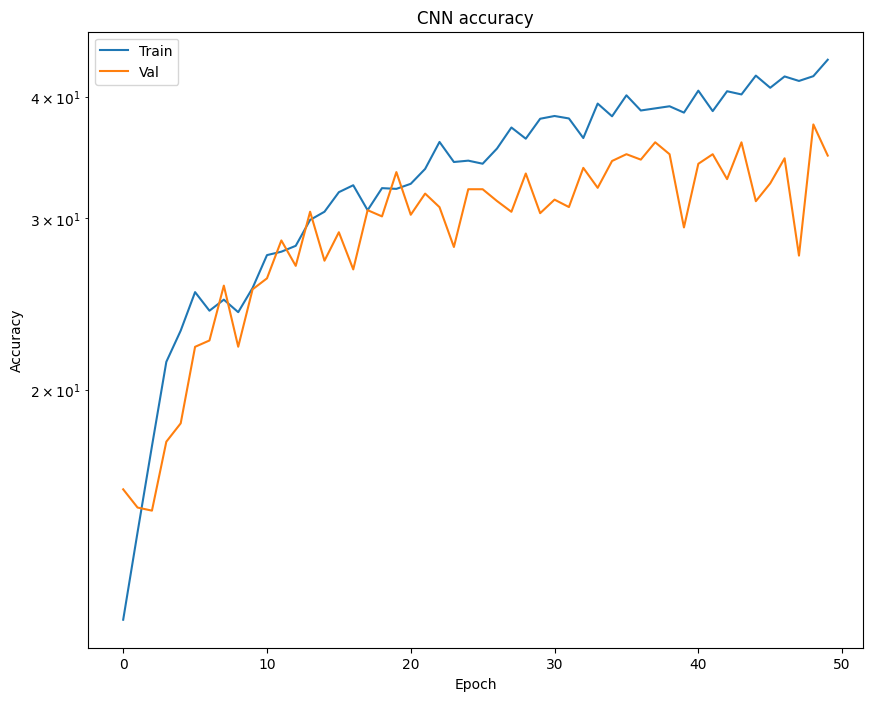

In [ ]:
# plot results
plot_results(results_cpu)

### Sample-Level Raw Waveform Model

### The Data

The main idea  behind the Sample-Lavel model its to use a raw signal that has small granularity from audio. Similar to character level in texts and pixel level on images.


### The Model

Given that we choose to use a network with mel-spectrograms to the first part of the essay, we decided to implement the strategy proposed in the article named "SAMPLE-LEVEL DEEP CONVOLUTIONAL NEURAL NETWORKS FOR
MUSIC AUTO-TAGGING USING RAW WAVEFORMS" by Jongpil Lee, Jiyoung Park, Keunhyoung Luke Kim, Juhan Nam, et al. [1], because it was cited in the article that the Sample raw input can be as good as the state of art mel-gram methods, it has more details about the model configuration:

- Conv 3-128: 19683x128
- Conv 3-128: 19683x128
- Max Pooling (3): 6561x128
- Conv 3-128: 6561x128
- Max Pooling (3): 2187x128
- Conv 3-256: 2187x256
- Max Pooling (3): 729x256
- Conv 3-256: 729x256
- Max Pooling (3): 243x256
- Conv 3-256: 243x256
- Max Pooling (3): 81x256
- Conv 3-256: 81x256
- Max Pooling (3): 27x256
- Conv 3-256: 27x256
- Max Pooling (3): 9x256
- Conv 3-256: 9x256
- Max Pooling (3): 3x256
- Conv 3-512: 3x512
- Max Pooling (3): 1x512
- Conv 1-512: 1x512
- Dropout (0.5): 1x512
- Output: 10x1 (sigmoid)


As our datasets only have 10 tags, we'll work with 10x1 on the output.



In [87]:
# Preparing the dataset.

audio_dir = "Data/genres_original"

img_gen_dir = 'Data/sample_level/'
if os.path.exists(img_gen_dir):
  shutil.rmtree(img_gen_dir)
  os.mkdir(img_gen_dir)
else:
  os.mkdir(img_gen_dir)

SR = 2205
DURATION = 29.1  # 19683 frames
genres = list(os.listdir(audio_dir))
for genre in genres:
  # creates folder for the gender.
  if not os.path.exists(os.path.join(img_gen_dir + f"{genre}")):
    os.mkdir(os.path.join(img_gen_dir + f"{genre}"))

  # add each file to the respective folder.
  for audio in glob.glob(os.path.join(audio_dir, f'{genre}',"*.wav"), recursive=True):
    if audio == "Data/genres_original/jazz/jazz.00054.wav":     # faulty audio
      continue

    src, sr = librosa.load(audio, sr=SR)  # whole signal
    sample=src[0:59049]

    fn = audio.split(".")[1]
    file = os.path.join(img_gen_dir, genre) + '/' + genre + fn+".npy"
    np.save(file, sample)

59049


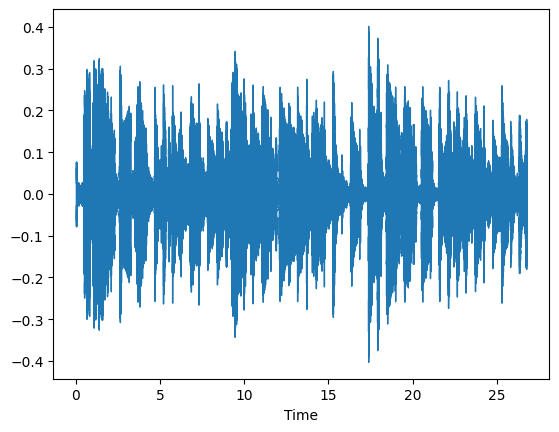

In [88]:
sample = np.load('/content/Data/sample_level/country/country00011.npy')
fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(sample, sr=sr, ax=ax)
print(len(sample))

In [90]:
# spliting dataset in train, test, val
train_dir, test_dir, val_dir = split_dataset('sample_level')

In [91]:
# loading dataset
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = load_dataset(train_dir, test_dir, val_dir)

In [84]:
# CNN modeling as described in [1].

# input: 59049x1

class sample_level_net(nn.Module):
  def __init__(self):
    super().__init__()

    # Conv 3×128 (output: 59049 x 1)
    self.conv1 = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, stride=3, padding=0),
        nn.BatchNorm1d(num_features=128),
        nn.ReLU())
    # Conv 3×128 - MP (3) (output: 19683 x 128)
    self.conv2 = nn.Sequential(
        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(num_features=128),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=3, stride=3))
    # Conv 3×128 - MP (3) (output: 6561 x 128)
    self.conv3 = nn.Sequential(
        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(num_features=128),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=3,stride=3))
    # Conv 3×256 - MP (3) (output: 2187 x 256)
    self.conv4 = nn.Sequential(
        nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(num_features=256),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=3,stride=3))
    # Conv 3×256 - MP (3) (output: 729 x 256)
    self.conv5 = nn.Sequential(
        nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(num_features=256),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=3,stride=3))
    # Conv 3×256 - MP (3) (output: 243 x 256)
    self.conv6 = nn.Sequential(
        nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(num_features=256),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=3,stride=3))
    # Conv 3×256 - MP (3) (output: 81 x 256)
    self.conv7 = nn.Sequential(
        nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(num_features=256),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=3,stride=3))
    # Conv 3×256 - MP (3) (output: 27 x 256)
    self.conv8 = nn.Sequential(
        nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(num_features=256),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=3,stride=3))
    # Conv 3×256 - MP (3) (output: 9 x 256)
    self.conv9 = nn.Sequential(
        nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(num_features=256),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=3,stride=3))
    # Conv 1x512 - MP (3) (output: 3 x 512)
    self.conv10 = nn.Sequential(
        nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(num_features=512),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=3,stride=3))
    # Conv 1x512 - MP (3) (output: 1 x 512)
    self.conv11 = nn.Sequential(
        nn.Conv1d(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm1d(num_features=512),
        nn.ReLU(),
        nn.Dropout(0.5))

    # Output: 1x10 (sigmoid)
    self.dense = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=512, out_features=10),
      nn.Sigmoid()
    )

  def forward(self, x):
      x = x.view(x.shape[0], 1,-1)

      out = self.conv1(x)
      out = self.conv2(out)
      out = self.conv3(out)
      out = self.conv4(out)
      out = self.conv5(out)
      out = self.conv6(out)
      out = self.conv7(out)
      out = self.conv8(out)
      out = self.conv9(out)
      out = self.conv10(out)
      out = self.conv11(out)
      out = self.dense(out)

      return out

In [85]:
# Model details
model = sample_level_net().to(device)

summary(model, (len(sample),sample.ndim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1           [-1, 128, 19683]             512
       BatchNorm1d-2           [-1, 128, 19683]             256
              ReLU-3           [-1, 128, 19683]               0
            Conv1d-4           [-1, 128, 19683]          49,280
       BatchNorm1d-5           [-1, 128, 19683]             256
              ReLU-6           [-1, 128, 19683]               0
         MaxPool1d-7            [-1, 128, 6561]               0
            Conv1d-8            [-1, 128, 6561]          49,280
       BatchNorm1d-9            [-1, 128, 6561]             256
             ReLU-10            [-1, 128, 6561]               0
        MaxPool1d-11            [-1, 128, 2187]               0
           Conv1d-12            [-1, 256, 2187]          98,560
      BatchNorm1d-13            [-1, 256, 2187]             512
             ReLU-14            [-1, 25

In [92]:
# Training with optimizer: torch.optim.SGD()
dataset = ConcatDataset([train_dataset, test_dataset])

k_folds = 5
num_epochs = 100
criterion = nn.CrossEntropyLoss()
splits=KFold(n_splits=k_folds,shuffle=True,random_state=42)
results = {}


results = train(model, partial(torch.optim.SGD, lr=0.001, momentum=0.9, nesterov=True), num_epochs, dataset, 'sample_level')

Fold 1
Epoch:1/100 AVG Training Loss:0.140 AVG Val Loss:0.151 AVG Training Acc 21.84 % AVG Val Acc 17.78 %
Epoch:2/100 AVG Training Loss:0.134 AVG Val Loss:0.143 AVG Training Acc 31.15 % AVG Val Acc 30.00 %
Epoch:3/100 AVG Training Loss:0.131 AVG Val Loss:0.139 AVG Training Acc 36.86 % AVG Val Acc 35.00 %
Epoch:4/100 AVG Training Loss:0.128 AVG Val Loss:0.138 AVG Training Acc 43.53 % AVG Val Acc 40.00 %
Epoch:5/100 AVG Training Loss:0.126 AVG Val Loss:0.135 AVG Training Acc 46.45 % AVG Val Acc 45.56 %
Epoch:6/100 AVG Training Loss:0.124 AVG Val Loss:0.133 AVG Training Acc 45.62 % AVG Val Acc 43.89 %
Epoch:7/100 AVG Training Loss:0.122 AVG Val Loss:0.132 AVG Training Acc 52.29 % AVG Val Acc 42.22 %
Epoch:8/100 AVG Training Loss:0.121 AVG Val Loss:0.131 AVG Training Acc 52.99 % AVG Val Acc 48.33 %
Epoch:9/100 AVG Training Loss:0.120 AVG Val Loss:0.131 AVG Training Acc 55.35 % AVG Val Acc 49.44 %
Epoch:10/100 AVG Training Loss:0.117 AVG Val Loss:0.131 AVG Training Acc 58.83 % AVG Val Acc 

In [94]:
# get results
results_cpu = get_results(results)

Performance of 5 fold cross validation
Average Training Loss: 0.100 	 Average Val Loss: 0.124 	 Average Training Acc: 88.79 	 Average Val Acc: 59.54


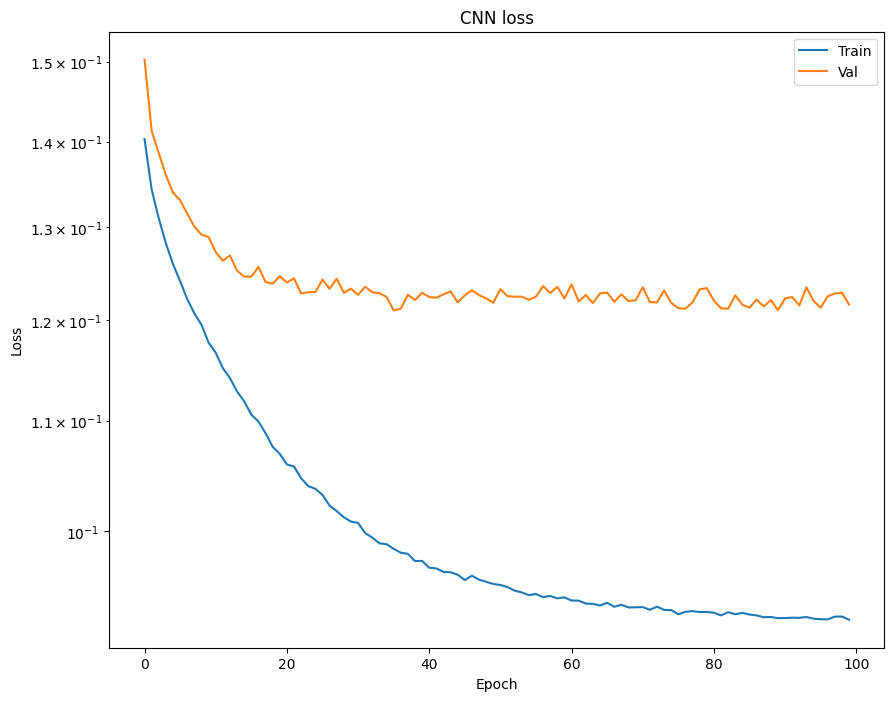

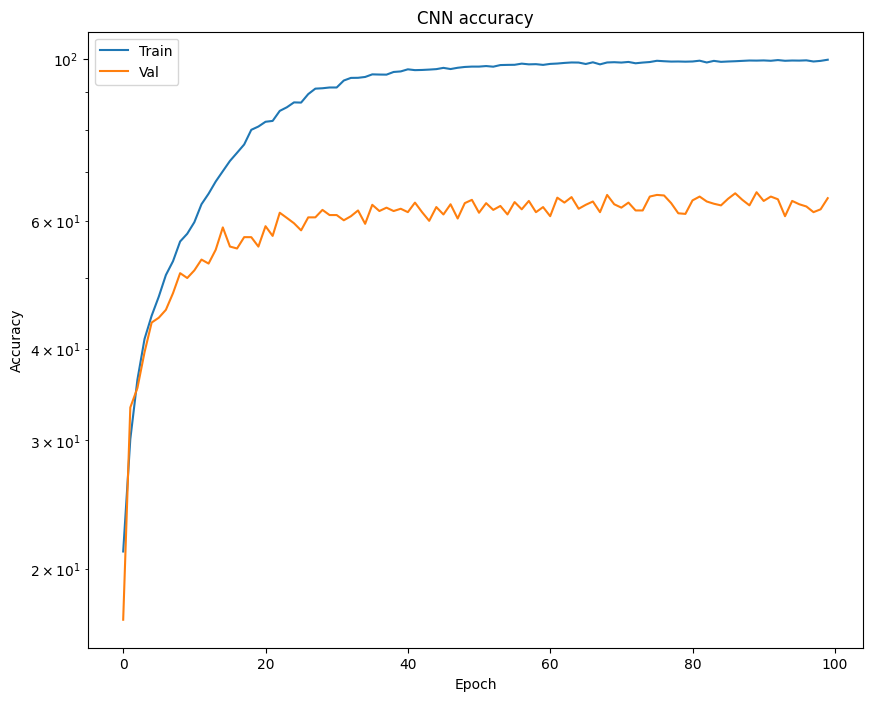

In [95]:
# plot results
plot_results(results_cpu)


### Learning Rate Scheduler Experiment





In [ ]:
dataset = ConcatDataset([train_dataset, test_dataset])

k_folds = 5
num_epochs = 50
criterion = nn.CrossEntropyLoss()
splits=KFold(n_splits=k_folds,shuffle=True,random_state=42)
results = {}

model = sample_level_net()

results = train(model, partial(torch.optim.SGD, lr=0.001, momentum=0.9, nesterov=True), num_epochs, dataset, 'sample_level')

Fold 1
Epoch:1/50 AVG Training Loss:0.142 AVG Val Loss:0.153 AVG Training Acc 14.19 % AVG Val Acc 8.33 %
Epoch:2/50 AVG Training Loss:0.142 AVG Val Loss:0.150 AVG Training Acc 15.58 % AVG Val Acc 20.56 %
Epoch:3/50 AVG Training Loss:0.141 AVG Val Loss:0.150 AVG Training Acc 20.45 % AVG Val Acc 23.33 %
Epoch:4/50 AVG Training Loss:0.141 AVG Val Loss:0.149 AVG Training Acc 20.58 % AVG Val Acc 23.33 %
Epoch:5/50 AVG Training Loss:0.140 AVG Val Loss:0.149 AVG Training Acc 22.25 % AVG Val Acc 22.78 %
Epoch:6/50 AVG Training Loss:0.140 AVG Val Loss:0.149 AVG Training Acc 23.37 % AVG Val Acc 23.33 %
Epoch:7/50 AVG Training Loss:0.139 AVG Val Loss:0.149 AVG Training Acc 27.82 % AVG Val Acc 22.78 %
Epoch:8/50 AVG Training Loss:0.139 AVG Val Loss:0.148 AVG Training Acc 25.17 % AVG Val Acc 22.78 %
Epoch:9/50 AVG Training Loss:0.138 AVG Val Loss:0.148 AVG Training Acc 27.40 % AVG Val Acc 24.44 %
Epoch:10/50 AVG Training Loss:0.138 AVG Val Loss:0.148 AVG Training Acc 28.65 % AVG Val Acc 22.22 %
Epo

In [ ]:
# get results
results_cpu = get_results(results)

Performance of 5 fold cross validation
Average Training Loss: 0.134 	 Average Val Loss: 0.146 	 Average Training Acc: 38.13 	 Average Val Acc: 31.17


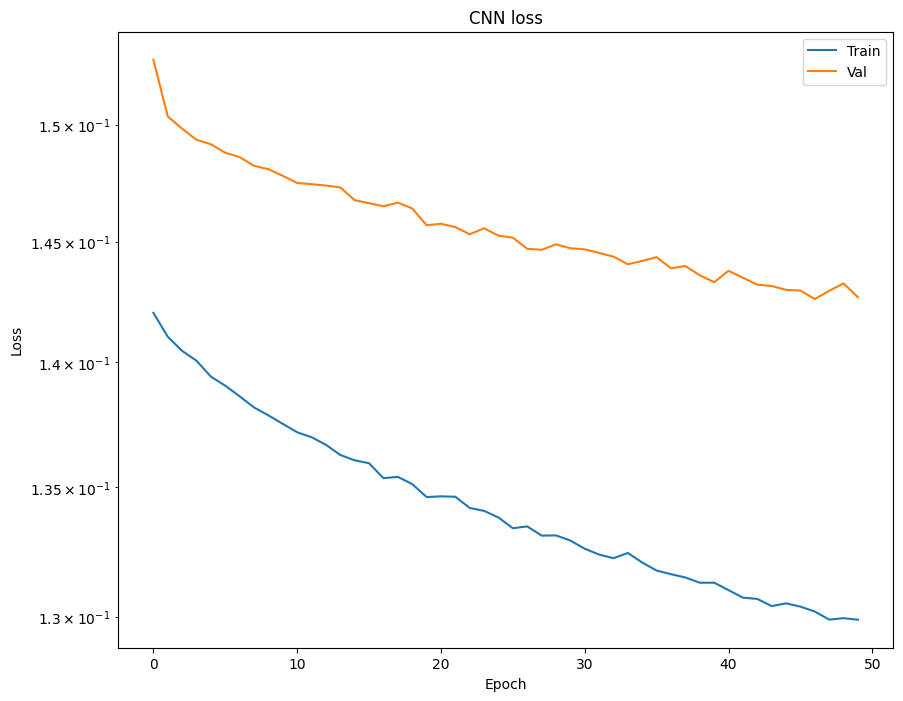

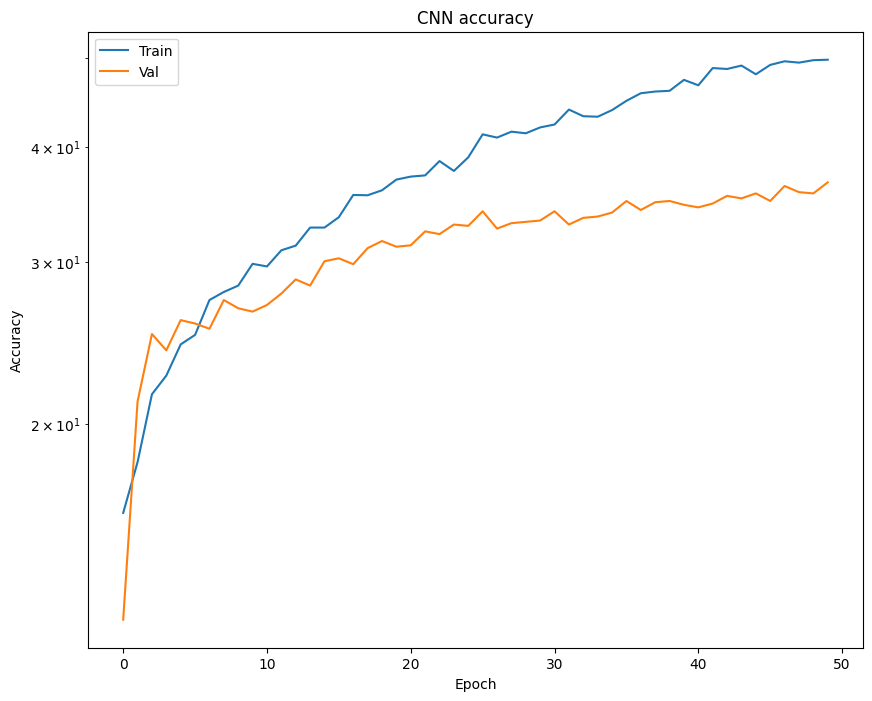

In [ ]:
# plot results
plot_results(results_cpu)

## Conclusion

Given the conditions of the dataset and the hardware resources we had to make small changes in the scope of the problem, but we were able to compare the two models, not for an auto-tagging model, but for a genre classification problem. The results given the fact that Mel-Frame Network has around 4 million parameters to fit, and our dataset is smaller than the one used in the article, our network couldn't achieve the same results as the purposed one. On the other hand, the Waveform-Sample Network has less than half of the parameters, so we suppose it works better with fewer data to learn, achieving a way higher accuracy than Mel-Frame on these conditions.

Another interesting result we had was in the attempt of incorporate learning rate schedulers, as suggested by the article, when we had worse results and the author of the article achieved better metrics.

Finally, as students, we were able to get in touch with the challenges of developing neural networks, dealing with small datasets, limited GPU resources, hyperparameters and architecture adaptations, etc.


## References


[1] Lee, J., Park, J., Kim, K. L., & Nam, J. (2017). Sample-level deep convolutional neural networks for music auto-tagging using raw waveforms. arXiv preprint arXiv:1703.01789.

[2] Choi, K., Fazekas, G., & Sandler, M. (2016). Automatic tagging using deep convolutional neural networks. arXiv preprint arXiv:1606.00298.

[3] Music Genre Classification With Python. https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8. (accessed Jun. 22, 2023).

[4] Sturm, B. L. (2013). The GTZAN dataset: Its contents, its faults, their effects on evaluation, and its future use. arXiv preprint arXiv:1306.1461.

[5] Choi, K., Fazekas, G., Sandler, M., & Cho, K. (2017, March). Convolutional recurrent neural networks for music classification. In 2017 IEEE International conference on acoustics, speech and signal processing (ICASSP) (pp. 2392-2396). IEEE.
